# Entrenamiento de un modelo convolucional con Data Augmentation
---
### Configuración General del Entorno de Trabajo

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = '/content/DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Flujo de trabajo con los datos

Implementamos una estrategia para transferir los datos desde Google Drive (almacenamiento permanente) al sistema de archivos local de Colab (almacenamiento volátil). El archivo Fingers.zip se descomprime en la máquina virtual para evitar los cuellos de botella característicos del acceso recurrente a archivos en Drive, especialmente notable cuando se trabaja con carpetas que contienen numerosos archivos (aunque el tamaño individual no sea grande). Este enfoque acelera significativamente las operaciones de lectura/escritura durante el procesamiento.


In [2]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive (asumiendo que está en la carpeta Fingers)
zip_path = os.path.join(DATOS_DIR, 'Fingers/Fingers.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: /content/DATOS/


### Preparación de los datos para Data Augmentation
La función **image_dataset_from_directory** de Keras permite cargar imágenes directamente desde una estructura de directorios, generando automáticamente un dataset etiquetado. Esta función asume que:

* Las imágenes están organizadas en subcarpetas, donde cada subcarpeta representa una clase distinta:
```plaintext
    directorio_dataset/
    │
    ├── clase_1/
    │   ├── imagen1.jpg
    │   ├── imagen2.jpg
    │   └── ...
    ├── clase_2/
    │   ├── imagen1.jpg
    │   └── ...
    └── ...
```
* El nombre de cada subcarpeta se utiliza como etiqueta de clase para las imágenes que contiene.
* Las imágenes se cargan en lotes (batches) de forma eficiente, sin necesidad de cargar todo el dataset en memoria a la vez.

Las ventajas principales son:
* Carga eficiente: carga en memoria los lotes que se están procesando.
* Preprocesamiento integrado: permite especificar redimensionamiento, modo de color (RGB, escala de grises) y normalización (también impacta en la eficiencia de estas transformaciones).
* División automática: soporta división entrenamiento/validación directamente.
* Optimización de rendimiento: integración nativa con tf.data para pipeline eficiente mejorando el tiempo de entrenamiento respecto de **ImageDataGenerator.flow_from_directory**.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import callbacks, optimizers
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (64, 64, 1)
N_CLASSES = 6
LOTES = 128

# Crear datasets usando tf.data (más moderno y eficiente)
def create_dataset(directory, validation_split=None, subset=None, shuffle=True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=123,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=LOTES,
        color_mode='grayscale',
        shuffle=shuffle
    )

    # Normalizar a [0,1] y aplicar data augmentation
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        #image = tf.image.rando .random_rotation(image, 0.2)  # ~45 grados
        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)  # Solo aumentar datos de entrenamiento

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(
    LOCAL_DIR + 'Fingers/train',
    validation_split=0.2,
    subset='training',
    shuffle=True
)

valid_ds = create_dataset(
    LOCAL_DIR + 'Fingers/train',
    validation_split=0.2,
    subset='validation',
    shuffle=False
)

test_ds = create_dataset(
    LOCAL_DIR + 'Fingers/test',
    shuffle=False
)


Found 18000 files belonging to 6 classes.
Using 14400 files for training.
Found 18000 files belonging to 6 classes.
Using 3600 files for validation.
Found 3600 files belonging to 6 classes.


### Muestra de algunas imagenes de la carpeta de entrenamiento utilizando el iterador

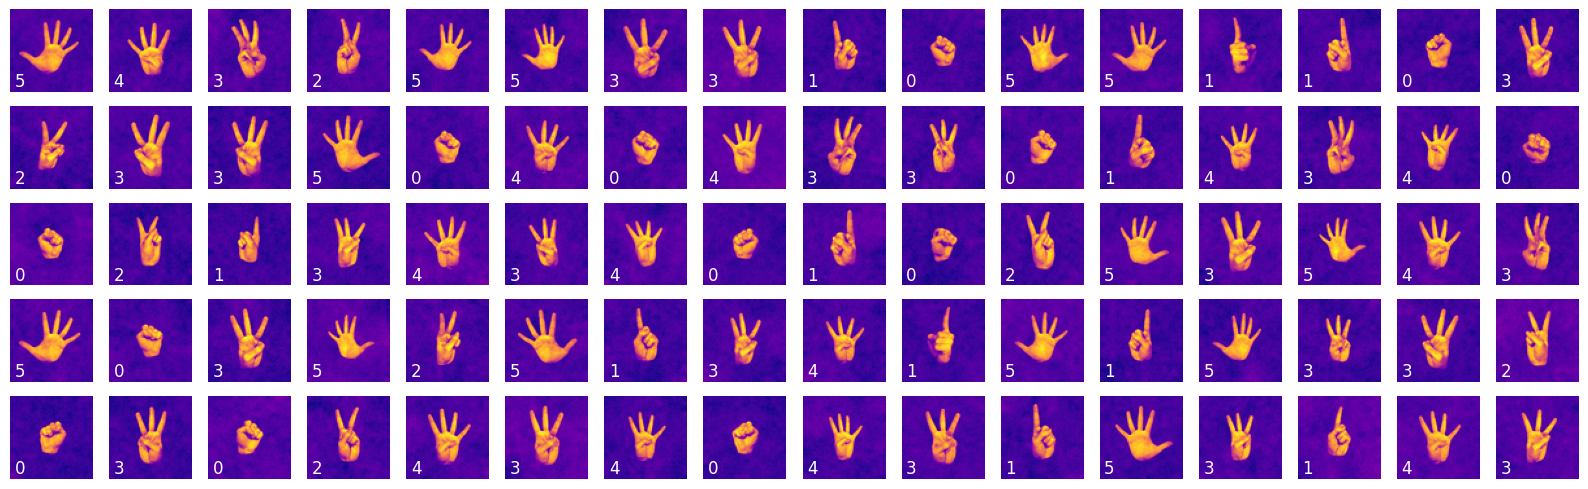

In [10]:
# Obtener un batch de datos del dataset de entrenamiento
for imagenes, etiquetas in train_ds.take(1):  # Toma el primer batch
    pass  # images y labels ahora contienen el primer lote de datos

COLOR_MAP = 'plasma'   #@param ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray']
filas = 5              #@param {type: "slider", min: 1, max: 10, step: 1}
columnas = 16          #@param {type: "slider", min: 8, max: 20, step: 2}

# Configuración de la grilla para dibujar imágenes
fig, axes = plt.subplots(filas, columnas, figsize=(columnas, filas))

# Itera sobre las imágenes del lote
for idx in range(min(filas * columnas, len(imagenes))):
    imagen = imagenes[idx].numpy().squeeze()  # Convierte a numpy y elimina dimensiones extra
    etiqueta = etiquetas[idx].numpy()          # Obtiene etiqueta (ya no es one-hot)

    (i, j) = (idx // columnas, idx % columnas) # Calcula la posición de la imagen en la grilla

    # grafica imagen con etiqueta en el borde inferior izquierdo
    axes[i, j].imshow(imagen, cmap=COLOR_MAP)
    axes[i, j].text(3, 59, str(etiqueta), color='white', fontsize=12, backgroundcolor='none')  # Etiqueta en esquina inferior izquierda
    axes[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

### Construcción y entrenamiento del modelo
Este ejemplo utiliza LeakyReLU como activación. Puede pasarse como parámetro **activation** de una capa Dense o Conv2D u omitirse y agregarse como capa independendiente. Si bien el funcioamiento es igual, para almacenar el modelo y poder recuperarlo es mejor agregarla como capa independiente.

In [5]:

# Tu modelo (sin cambios)
EPOCAS = 50
PACIENCIA = 4
ACTIVA = LeakyReLU()

model = Sequential()
model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation=ACTIVA))
model.add(Dense(N_CLASSES, activation='softmax'))

optimizer = optimizers.Adam(0.001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# Entrenar (cambia los iteradores por datasets)
H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.7900 - loss: 0.7131 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9964 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 5.5688e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9992 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 2.2266e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 8.6422e-05
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.3537e-04 - val_accuracy: 1.0000 - val_loss: 6.4319e-05
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2058e-04 - val_accuracy: 1.0000 - val_loss: 4.9828e-05
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.5517e-04 - val_accuracy: 1.0000 - val_loss: 4.0875e-05
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.

### Graficas y métricas de la evolución del modelo

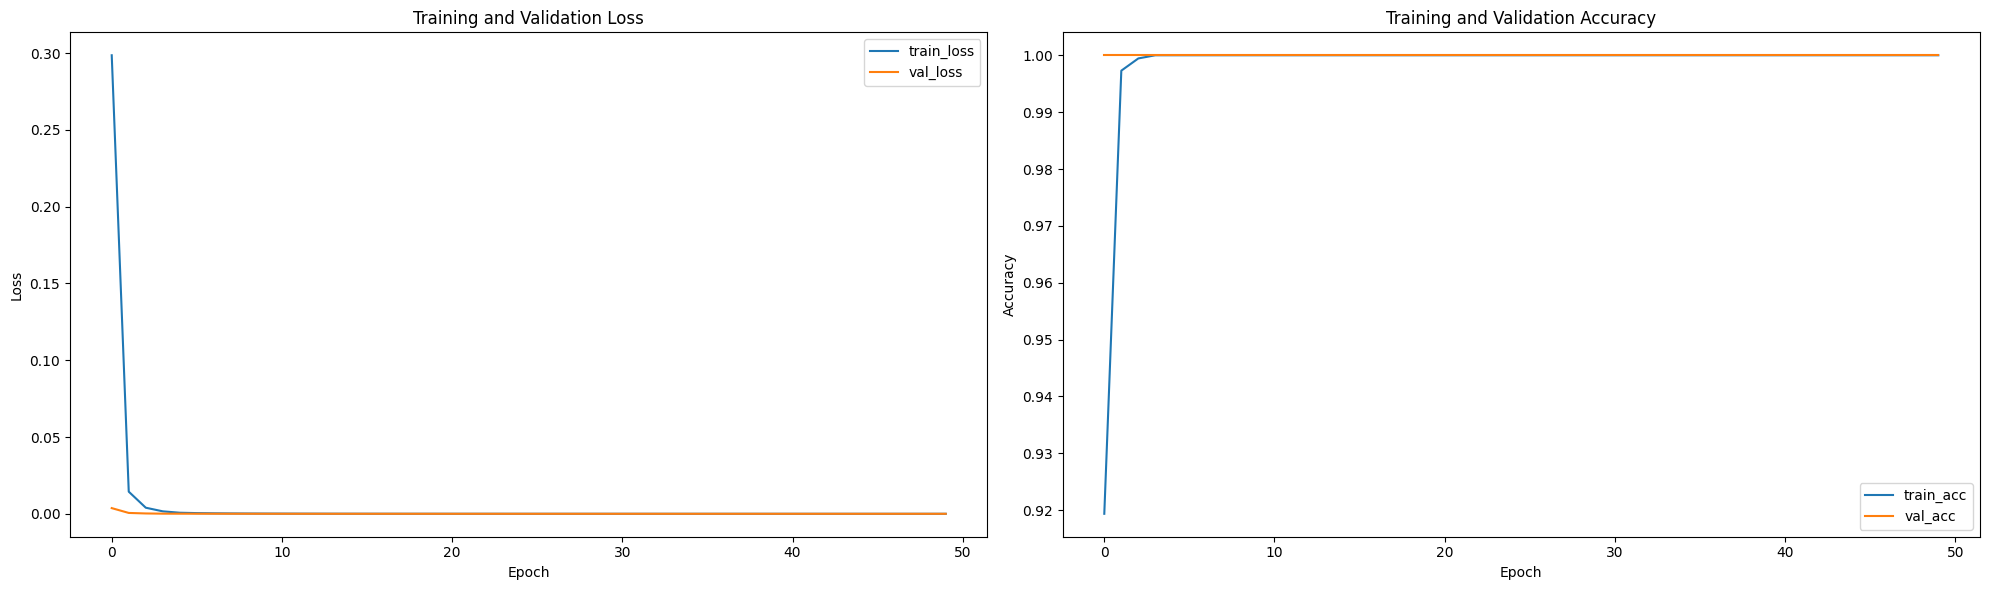


Efectividad del modelo con datos de entrenamiento: 100.00%
Efectividad del modelo con datos de Validación...: 100.00%
Efectividad del modelo con datos de Prueba.......: 100.00%


In [7]:
# Dibuja accuracy y loss del progreso del entrenamiento
plt.figure(figsize=(20, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# %% Evalúa el modelo
# Datos de entrenamiento
train_results = model.evaluate(train_ds, verbose=0)
print(f"\nEfectividad del modelo con datos de entrenamiento: {100*train_results[1]:6.2f}%")

# Datos de validación
val_results = model.evaluate(valid_ds, verbose=0)
print(f"Efectividad del modelo con datos de Validación...: {100*val_results[1]:6.2f}%")

# Datos de prueba
test_results = model.evaluate(test_ds, verbose=0)
print(f"Efectividad del modelo con datos de Prueba.......: {100*test_results[1]:6.2f}%")